# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
import matplotlib.pyplot as plt
from math import ceil
import numpy as np

# This is how you read in a png file

In [2]:
pics = os.listdir('data_imitation')
img = tf.io.read_file(os.path.join('data_imitation', pics[0]))

In [3]:
im2 = tf.io.decode_png(img)

(TensorShape([1400, 2240, 3]),
 tf.uint8,
 <matplotlib.image.AxesImage at 0x1b14b5c6310>)

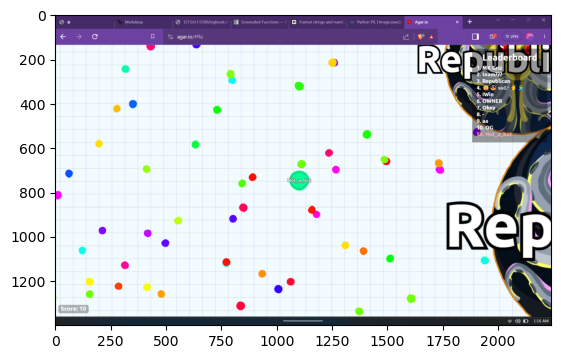

In [4]:
im2.shape, im2.dtype, plt.imshow(im2)

# This is how you make a dataset out from a directory

In [5]:
len(pics)

71

In [6]:
dataset = tf.data.Dataset.list_files('data_imitation\\*')
# This gives us a dataset of file names
# list(dataset.as_numpy_iterator())[:5]


In [7]:
input_shape = tf.io.decode_png(tf.io.read_file(dataset.as_numpy_iterator().next())).shape
input_shape

TensorShape([1400, 2240, 3])

In [8]:
def process_path(p):
    img = tf.io.decode_png(tf.io.read_file(p))
    name = tf.strings.split(p, os.sep)[-1]
    coord = tf.strings.substr(name, 11, 9)
    xy = tf.strings.split(coord, 'x')
    xy = tf.strings.to_number(xy, tf.int32)
    xy /= input_shape[:2]
    return img, xy

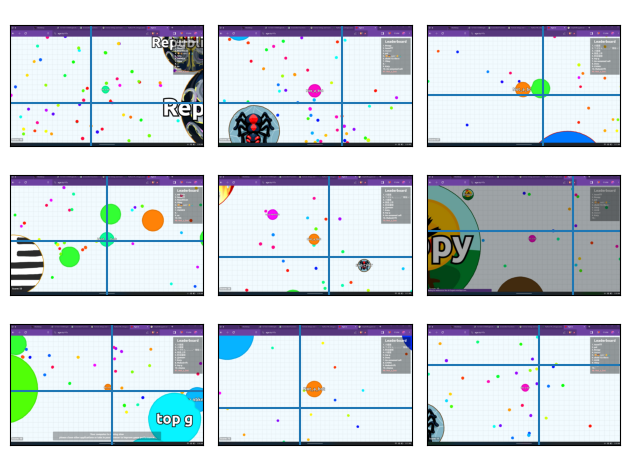

In [9]:
n = 9
cols = 3
plt.gca().axis('off')
for i, f in enumerate(dataset.take(n)):
    plt.subplot(ceil(n/cols), cols, i+1)
    # plt.gca().axis('off')
    plt.yticks([])
    plt.xticks([])
    img, xy = process_path(f)
    plt.imshow(img, 'gray')
    plt.axvline(img.shape[0]*xy[0])
    plt.axhline(img.shape[1]*xy[1])

plt.tight_layout()

# Process path is working well

In [10]:
dataset2 = dataset.map(process_path)

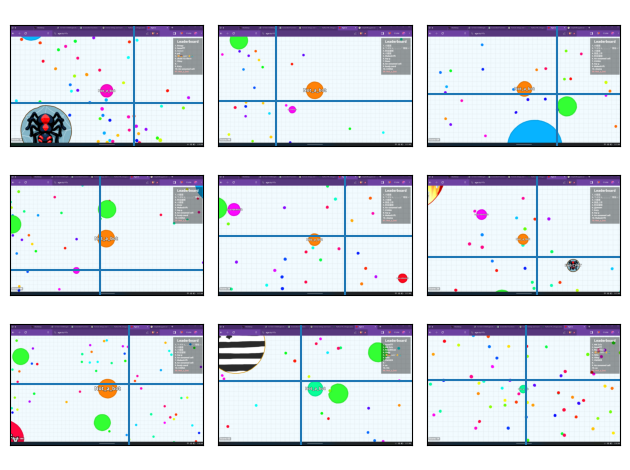

In [11]:
n = 9
cols = 3
plt.gca().axis('off')
for i, (img, xy) in enumerate(dataset2.take(n)):
    plt.subplot(ceil(n/cols), cols, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(img, 'gray')
    plt.axvline(img.shape[0]*xy[0])
    plt.axhline(img.shape[1]*xy[1])
plt.tight_layout()

# dataset2 is parsed properly

# Making the model

## Preprocessing layers

In [12]:
# Gray scaling and resizing
h = 50
w = h*input_shape[1]//input_shape[0]
preproc_layers = [
    layers.Rescaling(1./255, name='scaling_0-1'),
    # tf.image.rgb_to_grayscale,
    layers.Resizing(h, w, name=f'sizing_{h}-{w}')
    # layers.Resizing(50,50)
]
def preproc(x):
    for step in preproc_layers:
        x = step(x)
    return x
preproc_layers

In [13]:
preproc_shape = preproc(dataset2.as_numpy_iterator().next()[0]).shape
preproc_shape

TensorShape([50, 80, 3])

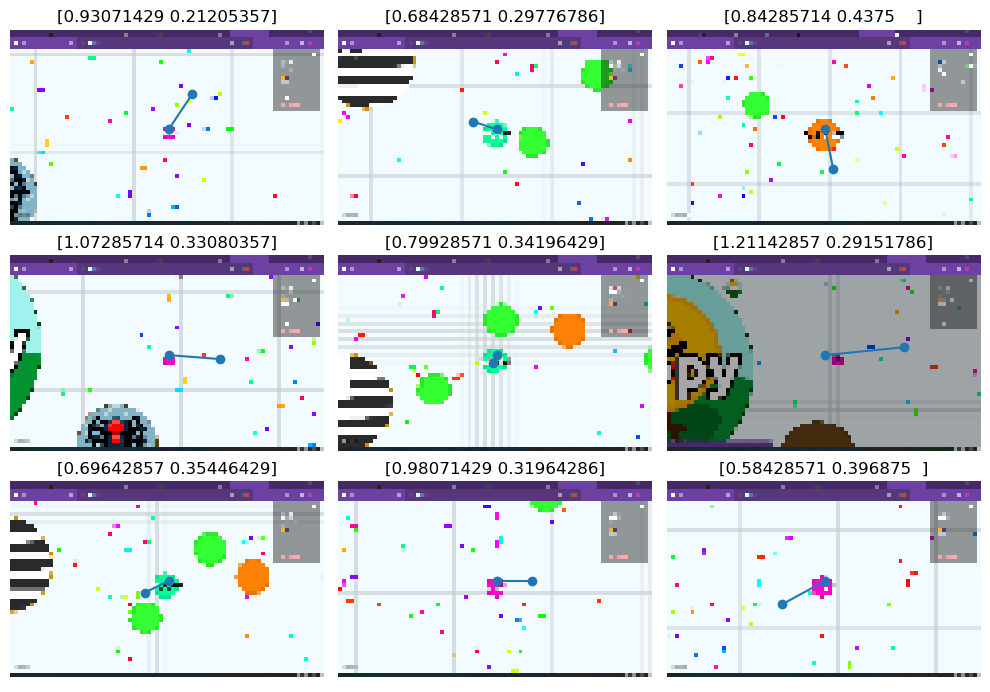

In [14]:
n = 9
cols = 3
plt.figure(figsize=(10,7))
plt.gca().axis('off')
for i, (img, xy) in enumerate(dataset2.take(n)):
    plt.subplot(ceil(n/cols), cols, i+1)
    plt.gca().axis('off')
    plt.imshow(preproc(img), 'gray')
    plt.title(xy.numpy())

    y, x = preproc_shape[:2]
    x//=2
    y//=2
    xy *= tuple(input_shape[:2])
    x_ = int(xy[0]) * preproc_shape[0] // input_shape[0]
    y_ = int(xy[1]) * preproc_shape[1] // input_shape[1]
    dx = x_ - x
    dy = y_ - y
    # dx = 0
    # dy = 0
    plt.plot([x, x+dx],[y, y+dy], 'o-')
plt.tight_layout()

# dataset2 is parsed properly

In [15]:
inputs = keras.Input(shape=input_shape, name="Screen Input Layer")
preprocess = preproc(inputs)
intermediate = [
    layers.Conv2D(32, 5, input_shape=preprocess.shape),
    layers.MaxPool2D(),
    layers.Conv2D(10, 5),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(100, activation='relu'),
]
# process = keras.Input(shape=preprocess.shape, name="Input Preprocessed Layer")
process = preprocess
for i, layer in enumerate(intermediate):
    process = layer(process)
    intermediate[i] = process
out_X = layers.Dense(10, activation=keras.activations.softmax)(process)
out_Y = layers.Dense(10, activation=keras.activations.softmax)(process)

coord_X = tf.argmax(out_X)/10*input_shape[0]
coord_Y = tf.argmax(out_Y)/10*input_shape[1]

inputs, preprocess, process, out_X, out_Y, coord_X, coord_Y

(<KerasTensor: shape=(None, 1400, 2240, 3) dtype=float32 (created by layer 'Screen Input Layer')>,
 <KerasTensor: shape=(None, 50, 80, 3) dtype=float32 (created by layer 'sizing_50-80')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_1')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_2')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_3')>,
 <KerasTensor: shape=(10,) dtype=float64 (created by layer 'tf.math.multiply')>,
 <KerasTensor: shape=(10,) dtype=float64 (created by layer 'tf.math.multiply_1')>)

In [55]:
coord_X = tf.argmax(out_X, 1)/10*input_shape[0]
coord_Y = tf.argmax(out_Y, 1)/10*input_shape[1]

In [16]:
preproc_shape

TensorShape([50, 80, 3])

In [17]:
intermediate

[<KerasTensor: shape=(None, 46, 76, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 23, 38, 32) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 19, 34, 10) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 9, 17, 10) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 1530) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_1')>]

## Custom Loss

In [18]:
class CoordCrossEntropyLoss(keras.losses.Loss):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true,(-1,))
        # print(y_true)
        trimmed = [min(i.numpy(),0.9) for i in y_true]
        # print(trimmed)
        y_true = [tf.one_hot(round(i*10), 10) for i in trimmed]
        y_true = tf.stack(y_true, 0)
        # print(y_true)
        y_pred = tf.reshape(y_pred, (-1, 10))
        return keras.losses.binary_crossentropy(y_true, y_pred)
        

In [19]:
model = keras.Model(preprocess, layers.concatenate([out_X, out_Y]))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 80, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 46, 76, 32)           2432      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 23, 38, 32)           0         ['conv2d[1][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 19, 34, 10)           8010      ['max_pooling2d[1][0]']   

In [20]:
model(preproc(np.random.random_sample((5, *input_shape)))).shape

TensorShape([5, 20])

In [56]:
model_X = keras.Model(inputs, coord_X)
model_Y = keras.Model(inputs, coord_Y)

In [47]:
model_X.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Screen Input Layer (InputL  [(None, 1400, 2240, 3)]   0         
 ayer)                                                           
                                                                 
 scaling_0-1 (Rescaling)     (None, 1400, 2240, 3)     0         
                                                                 
 sizing_50-80 (Resizing)     (None, 50, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 76, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 38, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 34, 10)        8010

In [48]:
model_Y.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Screen Input Layer (InputL  [(None, 1400, 2240, 3)]   0         
 ayer)                                                           
                                                                 
 scaling_0-1 (Rescaling)     (None, 1400, 2240, 3)     0         
                                                                 
 sizing_50-80 (Resizing)     (None, 50, 80, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 76, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 38, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 34, 10)        8010

# Compile and Fit

In [24]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=CoordCrossEntropyLoss(),
    run_eagerly=True
)
hist = model.fit(
    dataset2.map(lambda x,y: (preproc(x), y)).batch(32),
    epochs=10,
)

Epoch 1/10
3/3 [==============================] - 1s 159ms/step - loss: 0.2803
Epoch 2/10
3/3 [==============================] - 1s 231ms/step - loss: 0.2976
Epoch 3/10
3/3 [==============================] - 1s 241ms/step - loss: 0.3167
Epoch 4/10
3/3 [==============================] - 2s 293ms/step - loss: 0.2399
Epoch 5/10
3/3 [==============================] - 1s 281ms/step - loss: 0.2191
Epoch 6/10
3/3 [==============================] - 1s 265ms/step - loss: 0.2338
Epoch 7/10
3/3 [==============================] - 1s 207ms/step - loss: 0.2238
Epoch 8/10
3/3 [==============================] - 1s 214ms/step - loss: 0.2152
Epoch 9/10
3/3 [==============================] - 2s 275ms/step - loss: 0.2064
Epoch 10/10
3/3 [==============================] - 1s 227ms/step - loss: 0.2254


# Getting X, Y from the model

In [25]:
img, xy = dataset2.as_numpy_iterator().next()

In [58]:
# model(preproc(tf.stack([img])))
model_X(tf.stack([img])), model_Y(tf.stack([img]))


(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([1260.])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([896.])>)

In [59]:
input_shape

TensorShape([1400, 2240, 3])

In [54]:
tf.argmax(res, 1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([9], dtype=int64)>